# BERT-Based End-to-End NLP Review Rating Predictor

In [1]:
# @author: Rashedul Alam

In [2]:
# import sys
# !"{sys.executable}" -m pip install datasets transformers seaborn matplotlib scikit-learn torch


In [ ]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
from transformers.models.auto import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
import torch
import json
from pathlib import Path
from dataclasses import dataclass
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

c:\Users\rashe\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df = load_dataset("yelp_review_full")
df

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [6]:
df['train'][0]

{'label': 4,
 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}

In [7]:
df['test'][1]

{'label': 0,
 'text': "Don't waste your time.  We had two different people come to our house to give us estimates for a deck (one of them the OWNER).  Both times, we never heard from them.  Not a call, not the estimate, nothing."}

## Total unique labels are Five. 0-4 is mentioned as low rating to higher.

In [8]:
df['test'].unique('label')

[0, 2, 1, 3, 4]

## Selected 15k data from 650k for training and 4k for test and 2k for validation due to insufficient hardware support for faster training

In [9]:
train_small = df["train"].select(range(15000))
test_val_small = df["test"].select(range(6000))

In [10]:
train_small.shape

(15000, 2)

In [11]:
test_val_small.shape

(6000, 2)

In [12]:
## Converted it to pandas dataframe for my flexibility of work

In [13]:
train = pd.DataFrame(train_small)
test_val = pd.DataFrame(test_val_small)

In [14]:
test, val = train_test_split(
    test_val,
    test_size=2000,     
    stratify=test_val['label'],
    random_state=42
)

In [15]:
train.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


In [16]:
test.head()

,label,text
5843,0,This Salvation Army definitely has its fans. I...
5462,2,I usually love coming here for their Homemade ...
553,0,This might be the worst Chinese I've ever tast...
5058,4,"We love Osaka!!! They have very fresh, delici..."
2673,0,I really hope Native Newyorkers CORPORATE is p...


In [17]:
val.head()

,label,text
5698,2,Decent enough buffet with the typical findings...
1675,4,This is a restaurant I go to because I am hung...
1059,1,Blah...Very disappointing. I ended up at the S...
1007,2,I had Saturday brunch here this week and was t...
4963,3,Great place to eat! Not only is the food great...


In [18]:
print('Train Shape: ',train.shape)
print('Test Shape: ',test.shape)
print('Validation Shape: ',val.shape)

Train Shape:  (15000, 2)
Test Shape:  (4000, 2)
Validation Shape:  (2000, 2)


In [19]:
train['label'].value_counts()

label
2    3532
1    3307
3    2999
0    2827
4    2335
Name: count, dtype: int64

In [20]:
test.head()

,label,text
5843,0,This Salvation Army definitely has its fans. I...
5462,2,I usually love coming here for their Homemade ...
553,0,This might be the worst Chinese I've ever tast...
5058,4,"We love Osaka!!! They have very fresh, delici..."
2673,0,I really hope Native Newyorkers CORPORATE is p...


In [21]:
test['label'].value_counts()

label
0    929
1    799
3    782
2    776
4    714
Name: count, dtype: int64

## Train Data Distribution

In [22]:
label_map = {
    0: "1★",
    1: "2★",
    2: "3★",
    3: "4★",
    4: "5★"
}

train["stars"] = train["label"].map(label_map)
train.head()

,label,text,stars
0,4,dr. goldberg offers everything i look for in a...,5★
1,1,"Unfortunately, the frustration of being Dr. Go...",2★
2,3,Been going to Dr. Goldberg for over 10 years. ...,4★
3,3,Got a letter in the mail last week that said D...,4★
4,0,I don't know what Dr. Goldberg was like before...,1★


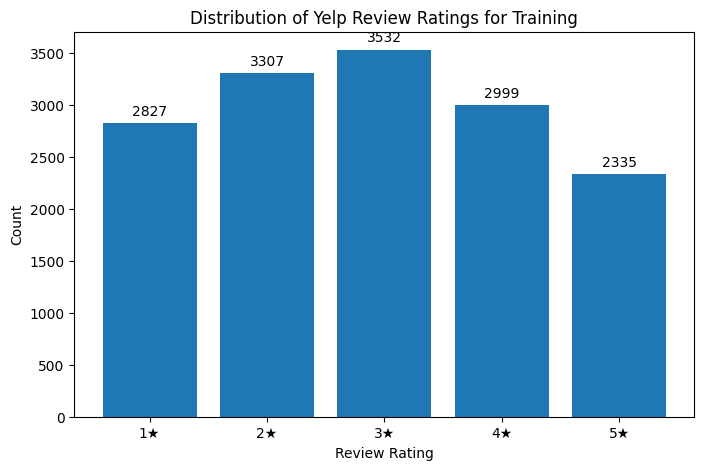

In [23]:
counts = train["stars"].value_counts().sort_index()

plt.figure(figsize=(8,5))
bars = plt.bar(counts.index, counts.values)

plt.title("Distribution of Yelp Review Ratings for Training")
plt.xlabel("Review Rating")
plt.ylabel("Count")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 50,     
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.show()


In [24]:
test.head()

,label,text
5843,0,This Salvation Army definitely has its fans. I...
5462,2,I usually love coming here for their Homemade ...
553,0,This might be the worst Chinese I've ever tast...
5058,4,"We love Osaka!!! They have very fresh, delici..."
2673,0,I really hope Native Newyorkers CORPORATE is p...


## Test Data

In [25]:
test["stars"] = train["label"].map(label_map)
train.head()

,label,text,stars
0,4,dr. goldberg offers everything i look for in a...,5★
1,1,"Unfortunately, the frustration of being Dr. Go...",2★
2,3,Been going to Dr. Goldberg for over 10 years. ...,4★
3,3,Got a letter in the mail last week that said D...,4★
4,0,I don't know what Dr. Goldberg was like before...,1★


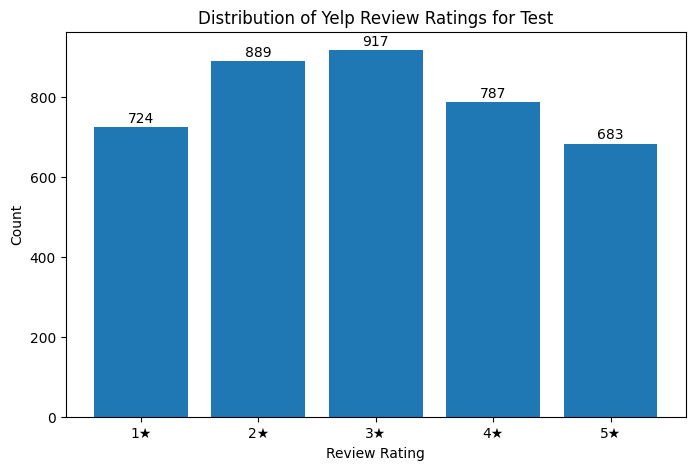

In [26]:
counts = test["stars"].value_counts().sort_index()

plt.figure(figsize=(8,5))
bars = plt.bar(counts.index, counts.values)

plt.title("Distribution of Yelp Review Ratings for Test")
plt.xlabel("Review Rating")
plt.ylabel("Count")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,     
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.show()


### Validation Data

In [27]:
val["stars"] = val["label"].map(label_map)
val.head()

,label,text,stars
5698,2,Decent enough buffet with the typical findings...,3★
1675,4,This is a restaurant I go to because I am hung...,5★
1059,1,Blah...Very disappointing. I ended up at the S...,2★
1007,2,I had Saturday brunch here this week and was t...,3★
4963,3,Great place to eat! Not only is the food great...,4★


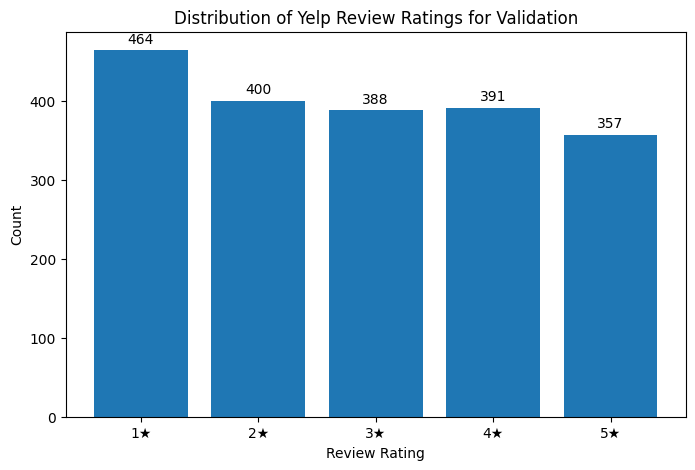

In [28]:
counts = val["stars"].value_counts().sort_index()

plt.figure(figsize=(8,5))
bars = plt.bar(counts.index, counts.values)

plt.title("Distribution of Yelp Review Ratings for Validation")
plt.xlabel("Review Rating")
plt.ylabel("Count")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,     
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.show()


In [29]:
train.head()

,label,text,stars
0,4,dr. goldberg offers everything i look for in a...,5★
1,1,"Unfortunately, the frustration of being Dr. Go...",2★
2,3,Been going to Dr. Goldberg for over 10 years. ...,4★
3,3,Got a letter in the mail last week that said D...,4★
4,0,I don't know what Dr. Goldberg was like before...,1★


## copied for future rollback

In [30]:
train_cp1 = train[['label', 'text']].copy()
val_cp1   = val[['label', 'text']].copy()
test_cp1  = test[['label', 'text']].copy()

In [31]:
train_cp1.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


## Lets go ahead

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   15000 non-null  int64 
 1   text    15000 non-null  object
 2   stars   15000 non-null  object
dtypes: int64(1), object(2)
memory usage: 351.7+ KB


In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 5843 to 2804
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4000 non-null   int64 
 1   text    4000 non-null   object
 2   stars   4000 non-null   object
dtypes: int64(1), object(2)
memory usage: 125.0+ KB


In [34]:
val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 5698 to 4302
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2000 non-null   int64 
 1   text    2000 non-null   object
 2   stars   2000 non-null   object
dtypes: int64(1), object(2)
memory usage: 62.5+ KB


## Saved the splits into my project

In [35]:
import os

os.makedirs("data/processed", exist_ok=True)

train.to_csv("data/processed/train.csv", index=False)
val.to_csv("data/processed/val.csv", index=False)
test.to_csv("data/processed/test.csv", index=False)

## Basic Confic

In [ ]:

@dataclass
class Config:
    model_name: str = "distilbert-base-uncased"   #DistilBERT
    max_len: int = 128
    batch_size: int = 16
    lr: float = 2e-5
    epochs: int = 5
    seed: int = 42

    data_dir: Path = Path("data/processed")
    model_dir: Path = Path("models/best_model_distilbert")

config = Config()


In [ ]:

class TextDataset(Dataset):
    def __init__(self, df, model_name):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=config.max_len,
            return_tensors="pt"
        )

        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = label
        return item


In [ ]:
train_df = pd.read_csv(config.data_dir / "train.csv")
val_df   = pd.read_csv(config.data_dir / "val.csv")

#label mapping (0–4 already, but we define explicitly)
labels = sorted(train_df["label"].unique())
label2id = {int(l): int(l) for l in labels}
id2label = {int(l): str(l) for l in labels}  #or map to stars text if you want

train_dataset = TextDataset(train_df, config.model_name)
val_dataset   = TextDataset(val_df, config.model_name)

## Metrics Function

In [39]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}


## Fine-tune DistilBERT

In [40]:
import os
os.makedirs("models/distilbert_outputs", exist_ok=True)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    config.model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="models/distilbert_outputs",
    num_train_epochs=config.epochs,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    learning_rate=config.lr,
    logging_dir="logs",
    logging_steps=200
    #no evaluation_strategy, no save_strategy, no load_best_model_at_end
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rashe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,1.308100
400,1.119100
600,1.080100
800,1.046300
1000,0.996300
1200,0.900100
1400,0.898900
1600,0.878700
1800,0.883000
2000,0.804400


c:\Users\rashe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\rashe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\rashe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\rashe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warn

TrainOutput(global_step=4690, training_loss=0.7537799143842034, metrics={'train_runtime': 71894.111, 'train_samples_per_second': 1.043, 'train_steps_per_second': 0.065, 'total_flos': 2483896608000000.0, 'train_loss': 0.7537799143842034, 'epoch': 5.0})

In [ ]:

save_dir = config.model_dir
save_dir.mkdir(parents=True, exist_ok=True)

trainer.model.save_pretrained(save_dir)

#tokenizer from TextDataset and save it
tokenizer = train_dataset.tokenizer        #will reuse same tokenizer
tokenizer.save_pretrained(save_dir)

#saveing label mappings
with open(save_dir / "label2id.json", "w") as f:
    json.dump(label2id, f)

with open(save_dir / "id2label.json", "w") as f:
    json.dump(id2label, f)

print("Model + tokenizer + label maps saved at:", save_dir)


Model + tokenizer + label maps saved at: models\best_model_distilbert


In [ ]:
model_dir = Path("models/best_model_distilbert")

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

with open(model_dir / "label2id.json") as f:
    label2id = json.load(f)
with open(model_dir / "id2label.json") as f:
    id2label = json.load(f)

model.eval()

def predict_text(text: str):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128,
    )
    with torch.no_grad():
        outputs = model(**inputs)
        probs = outputs.logits.softmax(dim=-1)
        pred_id = int(probs.argmax(dim=-1).item())
        confidence = float(probs[0, pred_id])
    return {
        "label_id": pred_id,
        "label_name": id2label[str(pred_id)] if str(pred_id) in id2label else id2label[pred_id],
        "confidence": confidence,
    }


## Performance on Validation Data

In [47]:
val_results = trainer.evaluate(eval_dataset=val_dataset)
val_results


c:\Users\rashe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.3271158933639526,
 'eval_accuracy': 0.543,
 'eval_precision': 0.5480599390606373,
 'eval_recall': 0.543,
 'eval_f1': 0.5447201004658375,
 'eval_runtime': 67.7398,
 'eval_samples_per_second': 29.525,
 'eval_steps_per_second': 1.845,
 'epoch': 5.0}

## Performance on Test Data

In [48]:
test_df = pd.read_csv(config.data_dir / "test.csv")
test_dataset = TextDataset(test_df, config.model_name)

In [50]:
test_results = trainer.evaluate(eval_dataset=test_dataset)
test_results


c:\Users\rashe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.2482799291610718,
 'eval_accuracy': 0.57925,
 'eval_precision': 0.5826212906167028,
 'eval_recall': 0.57925,
 'eval_f1': 0.5803689080109636,
 'eval_runtime': 136.4405,
 'eval_samples_per_second': 29.317,
 'eval_steps_per_second': 1.832,
 'epoch': 5.0}

In [52]:
os.listdir(config.model_dir)

['config.json',
 'id2label.json',
 'label2id.json',
 'model.safetensors',
 'special_tokens_map.json',
 'tokenizer.json',
 'tokenizer_config.json',
 'vocab.txt']

## Model Loading

In [53]:
model = AutoModelForSequenceClassification.from_pretrained(config.model_dir)
tokenizer = AutoTokenizer.from_pretrained(config.model_dir)


In [54]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [55]:
tokenizer

DistilBertTokenizerFast(name_or_path='models\best_model_distilbert', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [57]:
text = "Rashedul bought a chair and it was awesome!"
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-1.8595, -2.3728, -1.2534,  1.4842,  3.3979]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [58]:
probs = outputs.logits.softmax(dim=-1)
pred_id = torch.argmax(probs, dim=-1).item()
pred_id, probs

(4,
 tensor([[0.0045, 0.0027, 0.0082, 0.1266, 0.8581]], grad_fn=<SoftmaxBackward0>))

In [59]:
with open(config.model_dir / "id2label.json") as f:
    id2label = json.load(f)

id2label[str(pred_id)]


'4'

In [60]:
print("Stars:", int(id2label[str(pred_id)]) + 1, "★")

Stars: 5 ★


# Make Prediction on New Data

In [ ]:
def predict(text):
    
    inputs = tokenizer(
        text, 
        return_tensors="pt",
        truncation=True,
        padding=True
    )
    
    #run inference
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = logits.softmax(dim=-1)
        pred = probs.argmax().item()  #0–4
    
    stars_numeric = pred + 1                   #as our rating level starts from 0 so range will be 1–5
    star = "⭐"
    stars_text = star * stars_numeric          

    return {
        "label_id": pred,
        "label_name": id2label[str(pred)],      #original label mapping
        "stars_text": str(stars_numeric)+star,               
        "confidence": float(probs[0][pred])
    }


In [75]:
predict("Rashedul is amazing man! He works at Siemens Energy")


{'label_id': 4,
 'label_name': '4',
 'stars_text': '5⭐',
 'confidence': 0.9716299772262573}

In [ ]:
predict("Rashedul did scam! He works at Siemens Energy since 2024")


{'label_id': 0,
 'label_name': '0',
 'stars_text': '1⭐',
 'confidence': 0.9760466814041138}